---

<small><i>PROGRAM: Network Structural Properties & SIS dynamics (plots)
    
<small><i>AUTHOR: [Ivan Casanovas Rodríguez](https://github.com/ivancasanovaas)

<small><i>DATE: July, 2024
    
<small><i>DESCRIPTION: This program creates the plots for different properties of an undirected and unweighted network, and also includes the results of the SIS dynamics. The presented plots are about the degree distributions (direct and complementary cumulative), the correlations (average nearest neighbors degree and clustering coefficient), the prevalences (empirical and stationary), and the life-time distribution.
    
---


# Network Structural Properties & SIS dynamics (plots). OVERVIEW



<div class = "alert alert-info" style ="border-radius:10px;border-width:3px" >
    
    
0. [Import section](#0)
    1. [Data import](#0.1)
    2. [Extra functions](#0.2)
1. [Degree distributions, $P(k)$ & $P_c(k)$](#1)

2. [Correlations, $\bar{k}_{nn}(k)$ & $\bar{c}(k)$](#2)

3. [Empirical & stationary prevalences, $\rho_{emp}(t)$ & $\rho_{st}(\lambda)$](#3)
    
4. [Life-time distribution, $\psi(\tau)$](#4)



# 0. Import section <a class="anchor" id="0"></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'text.usetex': True,'font.family': 'serif',})
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

import os
import glob
import re

In [2]:
data_imp_path = '../results/dat/'
fig_exp_path = '../results/figs/'

## 0.1 Data import <a class="anchor" id="0.1"></a>

In [3]:
#------------------------------------------------------------------------------------------------------------------
# DATA IMPORT
#------------------------------------------------------------------------------------------------------------------

# List of degrees
D = pd.read_csv(data_imp_path+'/properties/degrees.txt',
                delim_whitespace=True, comment='#', header=None, names=[r'$i$',r'$D(i)$'], index_col=0)

# Degree distributions
ddd = pd.read_csv(data_imp_path+'/properties/ddd.txt',
                  delim_whitespace=True, comment='#', header=None, names=[r'$k$',r'$P(k)$'], index_col=0)
cdd = pd.read_csv(data_imp_path+'/properties/cdd.txt',
                  delim_whitespace=True, comment='#', header=None, names=[r'$k$',r'$P(k \leq K)$'], index_col=0)
ccdd = pd.read_csv(data_imp_path+'/properties/ccdd.txt',
                   delim_whitespace=True, comment='#', header=None, names=[r'$k$',r'$P_c(k)$'], index_col=0)

# Average nearest neighbors degree (original, RW & CM)
knn = pd.read_csv(data_imp_path+'/properties/knn.txt',
                  delim_whitespace=True, comment='#', header=None, names=[r'$k$',r'$\bar{k}_{nn}(k)$'], index_col=0, skiprows=2)
knn_rw = pd.read_csv(data_imp_path+'/properties/knn_rw100.txt',
                     delim_whitespace=True, comment='#', header=None, names=[r'$k$',r'$\bar{k}_{nn}(k)$'], index_col=0, skiprows=2)
knn_cm = pd.read_csv(data_imp_path+'/properties/knn_cm100.txt',
                     delim_whitespace=True, comment='#', header=None, names=[r'$k$',r'$\bar{k}_{nn}(k)$'], index_col=0, skiprows=2)

# Average clustering coefficient (original, RW & CM)
c = pd.read_csv(data_imp_path+'/properties/c.txt',
                delim_whitespace=True, comment='#', header=None, names=[r'$k$',r'$\bar{c}(k)$'], index_col=0)
c_rw = pd.read_csv(data_imp_path+'/properties/c_rw100.txt',
                   delim_whitespace=True, comment='#', header=None, names=[r'$k$',r'$\bar{c}(k)$'], index_col=0)
c_cm = pd.read_csv(data_imp_path+'/properties/c_cm100.txt',
                   delim_whitespace=True, comment='#', header=None, names=[r'$k$',r'$\bar{c}(k)$'], index_col=0)


## 0.2. Extra functions <a class="anchor" id="0.2"></a>

In [4]:
def axis_settings(ax,
                  xlabel=None,ylabel=None,
                  fontsize=None,
                  log_scale=None,semilog_scale=None):
    
    # Ticks of the plot
    ax.tick_params(axis="both", which ='major', direction="in", length=6, width=1, labelsize=fontsize)
    ax.tick_params(axis="both", which ='minor', direction="in", length=3, width=1, labelsize=fontsize)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    
    # Labels of the axis
    ax.set_xlabel(xlabel,fontsize=fontsize)
    ax.set_ylabel(ylabel,fontsize=fontsize)

    # Logarithm scale
    if log_scale == True:
        ax.set_xscale('log')
        ax.set_yscale('log')
     
    # Semi-logarithm scale
    if semilog_scale == True:
        ax.set_yscale('log')

    return ax



def powerlaw_model(x,A,alpha): # https://arxiv.org/pdf/1305.0215
    return A * x**(-alpha)



def compute_ccdf(data):
    
    """
    Computes the Complementary Cumulative Distribution Function (CCDF) of the data.
    
    INPUTS:
        data (list or np.array) : The input data for which the CCDF is to be computed.
        plot (bool) : If True, plots the CCDF. Default is True.

    OUTPUTS:
        sorted_data : 
        ccdf (plt.plot object): The CCDF plot object.
    """
    
    # Convert data to a numpy array if it's not already
    data = np.asarray(data)
    
    # Compute the cumulative distribution function (CDF)
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Compute the CCDF as 1 - CDF
    ccdf = 1 - cdf
    
    return sorted_data, ccdf

# 1. Degree distributions, $P(k)$ & $P_c(k)$ <a class="anchor" id="1"></a>

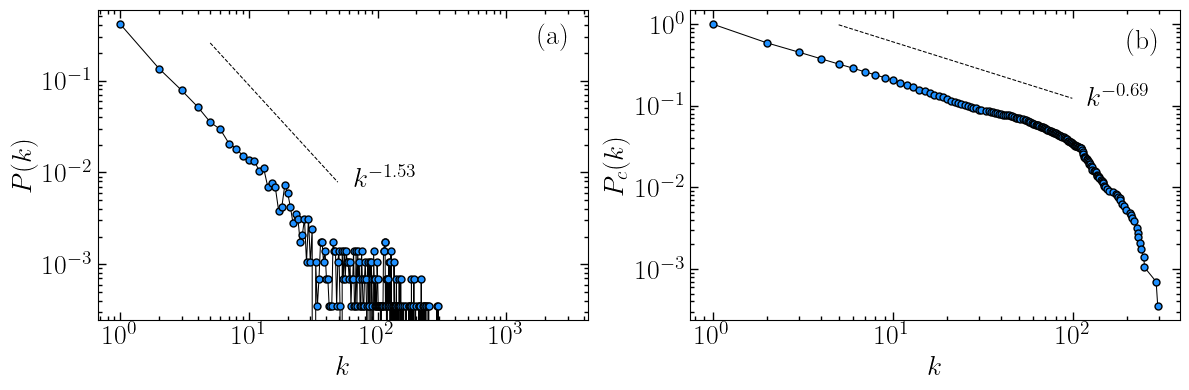

In [5]:
#------------------------------------------------------------------------------------------------------------------
# 1. DEGREE DISTRIBUTIONS
#------------------------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(1,2,figsize=(12,4))


# Direct Degree Distribution
#------------------------------------------------------------------------------------------------------------------

k = ddd.index
P_k = ddd.values.reshape(-1)

# Fitting to a power law 
x_data = np.array(k,dtype=float)
y_data = np.array(P_k, dtype=float)
from scipy.optimize import curve_fit
popt, pcov = curve_fit(powerlaw_model, x_data, y_data)
x_fit = np.arange(5,50)
y_fit = powerlaw_model(x_fit, 3, popt[1])

axs[0].plot(k, P_k,
        marker ='o',linestyle='-',color='black',linewidth=0.75,markerfacecolor='dodgerblue',markersize=5)
axs[0].plot(x_fit,y_fit, color='black', linewidth=0.75, linestyle='--', label=f'$k^{{-{popt[1]:.2f}}}$')

axs[0].text(65, 0.007, f'$k^{{-{popt[1]:.2f}}}$',fontsize=20)

axs[0] = axis_settings(axs[0],
                       xlabel=ddd.index.name,ylabel=ddd.columns[0],
                       fontsize=20,
                       log_scale=True,semilog_scale=None)


# Complementary Cumulative Degree Distribution
#------------------------------------------------------------------------------------------------------------------

k = ccdd.index
Pc_k = ccdd.values.reshape(-1)

# Fitting to a power law 
x_data = np.array(k,dtype=float)[np.array(k,dtype=float)<100]
y_data = np.array(Pc_k, dtype=float)[np.array(k,dtype=float)<100]
from scipy.optimize import curve_fit
popt, pcov = curve_fit(powerlaw_model, x_data, y_data)
x_fit = np.arange(5,100)
y_fit = powerlaw_model(x_fit, 3, popt[1])

axs[1].plot(k, Pc_k,
        marker ='o',linestyle='-',color='black',linewidth=0.75,markerfacecolor='dodgerblue',markersize=5)
axs[1].plot(x_fit,y_fit, color='black', linewidth=0.75, linestyle='--', label=f'$k^{{-{popt[1]:.2f}}}$')

axs[1].text(120, 0.1, f'$k^{{-{popt[1]:.2f}}}$',fontsize=20)

axs[1] = axis_settings(axs[1],
                       xlabel=ccdd.index.name,ylabel=ccdd.columns[0],
                       fontsize=20,
                       log_scale=True,semilog_scale=None)


#------------------------------------------------------------------------------------------------------------------

axs[0].text(1.75*10**3, 0.25, '(a)',fontsize=20, fontdict={'weight': 'bold'})
axs[1].text(2*10**2, 0.5, '(b)',fontsize=20, fontdict={'weight': 'bold'})

plt.tight_layout()
plt.savefig(fig_exp_path+'1-degree_distributions.pdf')

# 2. Correlations, $\bar{k}_{nn} (k)$ & $\bar{c}(k)$ <a class="anchor" id="2"></a>

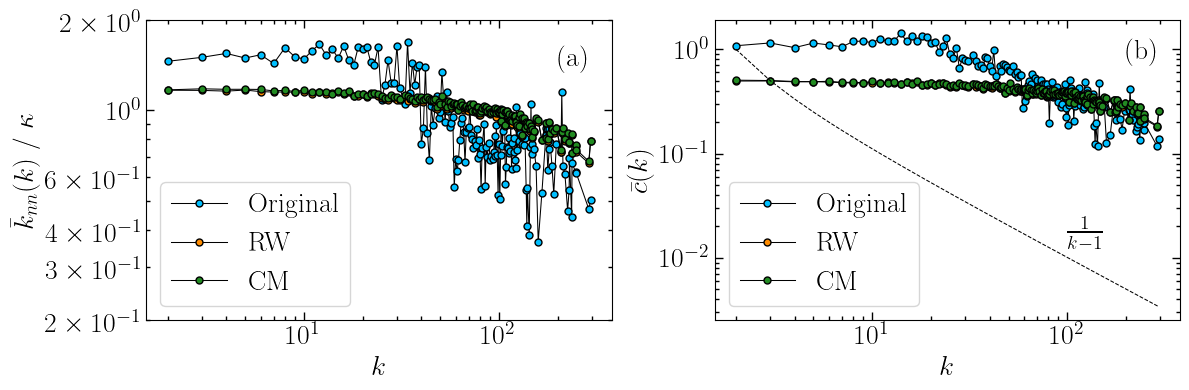

In [6]:
#------------------------------------------------------------------------------------------------------------------
# 2. CORRELATIONS
#------------------------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(1,2,figsize=(12,4))


# Average nearest neighbors degree
#------------------------------------------------------------------------------------------------------------------
k = knn.index[knn[knn.columns[0]] != 0]
knn_k = knn.values.reshape(-1)[knn[knn.columns[0]] != 0][k<2000]
axs[0].plot(k, knn_k,
        marker ='o',linestyle='-',color='black',linewidth=0.75,markerfacecolor='deepskyblue',markersize=5, label='Original')

k_rw = knn_rw.index[knn_rw[knn_rw.columns[0]] != 0]
knn_k_rw = knn_rw.values.reshape(-1)[knn_rw[knn_rw.columns[0]] != 0][k_rw<2000]
axs[0].plot(k_rw[k_rw<2000], knn_k_rw,
        marker ='o',linestyle='-',color='black',linewidth=0.75,markerfacecolor='darkorange',markersize=5, label='RW')

k_cm = knn_cm.index[knn_rw[knn_cm.columns[0]] != 0]
knn_k_cm = knn_cm.values.reshape(-1)[knn_cm[knn_cm.columns[0]] != 0][k_cm<2000]
axs[0].plot(k_cm[k_cm<2000], knn_k_cm,
        marker ='o',linestyle='-',color='black',linewidth=0.75,markerfacecolor='forestgreen',markersize=5, label='CM', )

axs[0] = axis_settings(axs[0],
                   xlabel=knn.index.name,ylabel=fr'{knn.columns[0]} / $\kappa$',
                   fontsize=20,
                   log_scale=True,semilog_scale=None)
axs[0].set_ylim(2*10**(-1),2)
axs[0].legend(loc='lower left', fontsize=20, frameon=True)


# Average clustering coefficient
#------------------------------------------------------------------------------------------------------------------

k = c.index[c[c.columns[0]] != 0]
c_k = c.values.reshape(-1)[c[c.columns[0]] != 0]
axs[1].plot(k, c_k,
        marker ='o',linestyle='-',color='black',linewidth=0.75,markerfacecolor='deepskyblue',markersize=5, label='Original')

k_rw = c_rw.index[c_rw[c_rw.columns[0]] != 0]
c_k_rw = c_rw.values.reshape(-1)[c_rw[c_rw.columns[0]] != 0]
axs[1].plot(k_rw, c_k_rw,
        marker ='o',linestyle='-',color='black',linewidth=0.75,markerfacecolor='darkorange',markersize=5, label='RW')

k_cm = c_cm.index[c_rw[c_cm.columns[0]] != 0]
c_k_cm = c_cm.values.reshape(-1)[c_cm[c_cm.columns[0]] != 0]
axs[1].plot(k_cm, c_k_cm,
        marker ='o',linestyle='-',color='black',linewidth=0.75,markerfacecolor='forestgreen',markersize=5, label='CM')

# Strong vs Weak clustering
axs[1].plot(k, 1/(k-1), color='black', linewidth=0.75, linestyle='--')
axs[1].text(100, 0.015, r'$\frac{1}{k-1}$',fontsize=20)

axs[1] = axis_settings(axs[1],
                   xlabel=c.index.name,ylabel=fr'{c.columns[0]}',
                   fontsize=20,
                   log_scale=True,semilog_scale=None)

axs[1].legend(loc='lower left', fontsize=20, frameon=True)


#------------------------------------------------------------------------------------------------------------------

axs[0].text(2*10**2, 1.4, '(a)',fontsize=20, fontdict={'weight': 'bold'})
axs[1].text(2*10**2, 0.8, '(b)',fontsize=20, fontdict={'weight': 'bold'})

plt.tight_layout()
plt.savefig(fig_exp_path+'2-correlations.pdf')

# 3. Empirical & stationary prevalences, $\rho_{emp}(t)$ & $\rho_{st}(\lambda)$  <a class="anchor" id="3"></a>

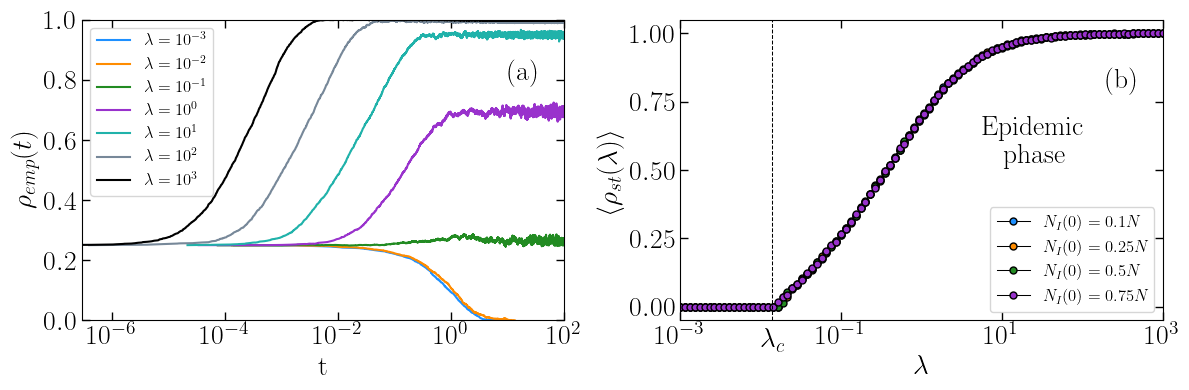

In [7]:
#------------------------------------------------------------------------------------------------------------------
# 3. EMPIRICAL AND STATIONARY PREVALENCES
#------------------------------------------------------------------------------------------------------------------

fig, axs = plt.subplots(1,2,figsize=(12,4))


# Empirical prevalence as a function of time
#------------------------------------------------------------------------------------------------------------------

folder = data_imp_path+'SIS/SIS-rho_t'
pattern = 'SIS-rho_t_lambda*'
path = os.path.join(folder, pattern)
files = glob.glob(path)

Nmcs = 1000000
times = pd.DataFrame(index = np.arange(0,Nmcs))
rhos = pd.DataFrame(index = np.arange(0,Nmcs))
for file in files:
    rho_t = pd.DataFrame(np.loadtxt(file))
    match = re.search(fr'{pattern[:-1]}([\d.]+)\.txt', file)
    if match:
        lambda_ = float(match.group(1))
        times[lambda_] = rho_t[0]
        rhos[lambda_] = rho_t[1]

lambdas = list(rhos.columns)
times = times.replace(np.nan,0)
rhos = rhos.replace(np.nan,0)

colors = ['dodgerblue','darkorange','forestgreen','darkorchid','lightseagreen','lightslategrey','black']
for i,lambda_ in enumerate(sorted(lambdas)):
    axs[0].plot(times[times[lambda_] != 0][lambda_], rhos[times[lambda_] != 0][lambda_],
                linestyle='-',color=colors[i],linewidth=1.5, label=fr'$\lambda = 10^{{{round(np.log10(lambda_))}}}$')
                
axs[0] = axis_settings(axs[0],
                       xlabel=r't',ylabel=r'$\rho_{emp}(t)$',
                       fontsize=20,
                       log_scale=None,semilog_scale=None)

axs[0].set_xscale('log')

axs[0].set_xlim(3*10**(-7),10**2)
axs[0].set_ylim(0,1)

axs[0].set_xticks([10**(-6),10**(-4),10**(-2),1,10**2])

axs[0].legend(loc='upper left',fontsize=12,ncol=1)


# Stationary prevalence as a function of the infection rate
#------------------------------------------------------------------------------------------------------------------
folder = data_imp_path+'SIS/SIS-rho_st'
pattern = 'SIS-rho_st_*'
path = os.path.join(folder, pattern)
files = glob.glob(path)

rhos_st = pd.DataFrame()
for file in files:
    rho_st = pd.read_csv(file, header=None).mean().values[0]
    match = re.search(r'SIS-rho_st_([\d.]+)N_lambda([\d.]+)\.txt', file)
    if match:
        n = float(match.group(1))
        lambda_ = float(match.group(2))
        rhos_st.loc[n,lambda_] = rho_st

lambdas = list(rhos_st.columns)
ns = sorted(list(rhos_st.index))

rhos_st = rhos_st[sorted(lambdas)]


colors = ['dodgerblue','darkorange','forestgreen','darkorchid']

for i,n in enumerate(ns):
#n = 0.25
#i = 0
    axs[1].plot(sorted(lambdas), rhos_st.loc[n],
            marker ='o',linestyle='-',color='black',linewidth=0.75,markerfacecolor=colors[i],markersize=5, label=fr'$N_I(0) = {n} N$')

axs[1] = axis_settings(axs[1],
                   xlabel=r'$\lambda$',ylabel=r'$ \langle \rho_{st} (\lambda) \rangle$',
                   fontsize=20,
                   log_scale=None,semilog_scale=None)
axs[1].set_xscale('log')

axs[1].axvline(x=0.014, color='black', linewidth=0.75, linestyle='--' )
axs[1].text(0.01,-0.15, r'$\lambda_c$',fontsize=20 )

axs[1].text(25, 0.6, 'Epidemic \n phase',fontsize=20, ha='center', va='center')

axs[1].set_xlim(10**-3,10**3)

axs[1].legend(loc='lower right',fontsize=12,ncol=1)


#------------------------------------------------------------------------------------------------------------------

axs[0].text(10, 0.8, '(a)',fontsize=20, fontdict={'weight': 'bold'})
axs[1].text(2*10**2, 0.8, '(b)',fontsize=20, fontdict={'weight': 'bold'})

plt.tight_layout()
plt.savefig(fig_exp_path+'3-SIS_rhos.pdf')

# 4. Life-time distribution, $\psi(\tau)$ <a class="anchor" id="4"></a>

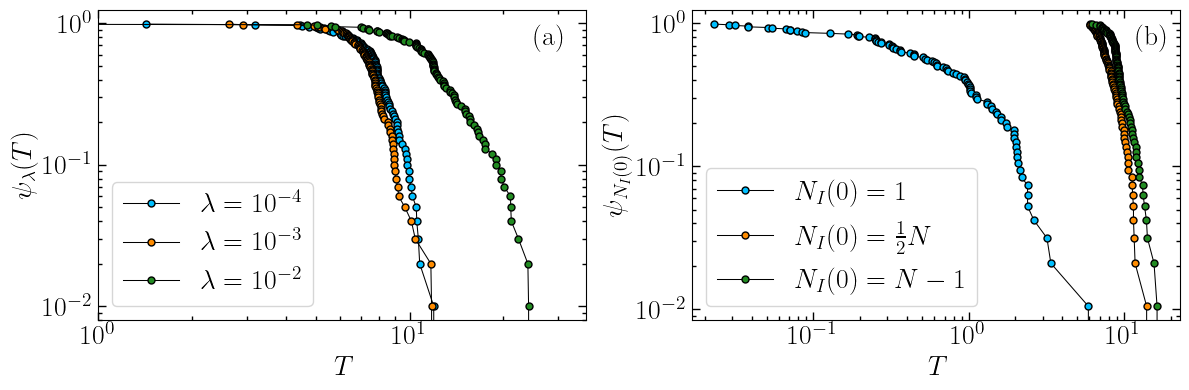

In [8]:
#------------------------------------------------------------------------------------------------------------------
# 4. LIFE-TIME DISTRIBUTIONS
#------------------------------------------------------------------------------------------------------------------

fig, axs = plt.subplots(1,2,figsize=(12,4))

folder = data_imp_path+'SIS/SIS-life_time'
pattern = 'SIS-life_time_lambda*'
path = os.path.join(folder, pattern)
files = glob.glob(path)

lambdas = []
for file in files:
    match = re.search(r'SIS-life_time_lambda([\d.]+)\.txt', file)
    if match:
        lambda_ = "{:.8f}".format(float(match.group(1)))
        lambdas.append(lambda_)
        
lambdas = np.array(lambdas)

Ni0s = pd.DataFrame()
times = pd.DataFrame()
for lambda_ in lambdas:
    file = data_imp_path+f'SIS/SIS-life_time/SIS-life_time_lambda{lambda_}.txt'
    times_Ni0 = pd.read_csv(file,comment='#',header=None,delim_whitespace=True)
    Ni0s[lambda_] = times_Ni0[0]
    times[lambda_] = times_Ni0[1]
 
lambdas = np.array(lambdas,dtype=float)
Ni0s = Ni0s[Ni0s.columns[0]].values
times.index = Ni0s
times.columns = lambdas

colors = ['deepskyblue','darkorange','forestgreen']


# As a function of the infection rate
#------------------------------------------------------------------------------------------------------------------

lambdas_interest = [0.0001,0.00102,0.01]

for i,lambda_ in enumerate(lambdas_interest):

    data = times[lambda_].values
    sorted_data, ccdf = compute_ccdf(data)

    axs[0].plot(sorted_data, ccdf,
                marker ='o',linestyle='-',color='black',linewidth=0.75,markerfacecolor=colors[i],markersize=5, label=fr'$\lambda = 10^{{{round(np.log10(lambda_))}}}$')

axs[0] = axis_settings(axs[0],
                       xlabel=r'$T$',ylabel=r'$\psi_{\lambda} (T)$',
                       fontsize=20,
                       log_scale=True,semilog_scale=None)

axs[0].set_xlim(1)

axs[0].legend(loc='lower left',fontsize=20,ncol=1)


# As a function of the initial number of infected nodes
#------------------------------------------------------------------------------------------------------------------

Ni0s_interest = [Ni0s[0],Ni0s[round(len(Ni0s)/2)],Ni0s[-1]]
ns = [r'$1$',r'$\frac{1}{2}N$',r'$N-1$']

for i,Ni0 in enumerate(Ni0s_interest):

    data = times.loc[Ni0].values
    sorted_data, ccdf = compute_ccdf(data)

    axs[1].plot(sorted_data, ccdf,
                marker ='o',linestyle='-',color='black',linewidth=0.75,markerfacecolor=colors[i],markersize=5, label=fr'$N_I(0) =$ {ns[i]}')

axs[1] = axis_settings(axs[1],
                       xlabel=r'$T$',ylabel=r'$\psi_{N_I(0)} (T)$',
                       fontsize=20,
                       log_scale=True,semilog_scale=None)

axs[1].legend(loc='lower left',fontsize=20,ncol=1)

#------------------------------------------------------------------------------------------------------------------

axs[0].text(25, 0.7, '(a)',fontsize=20, fontdict={'weight': 'bold'})
axs[1].text(12, 0.7, '(b)',fontsize=20, fontdict={'weight': 'bold'})

plt.tight_layout()
plt.savefig(fig_exp_path+'4-SIS_lifetimes.pdf')